# Ordinary differential equation models 

Ordinary differential equation models are useful for modeling systems that evolve over time. The system is defined by a set of variables, such as concentrations of chemicals or abundances of species, and a set of equations that describe the rate of change of species. A popular ODE model for describing the dynamics of microbial communities is the generalized Lotka-Volterra (gLV) model. For any species $x_i$, the rate of change of that species depends on a pair-wise interaction with all other species in the community, 

$$
\frac{ d x_i } { d t} = x_i \left( r_i + \sum_{j=1}^{n_s} a_{ij} x_j \right) 
$$
where $r_i$ is the growth rate of species $i$ and $a_{ij}$ is a constant that represents how species $j$ affects the growth rate of species $i$. The solution of an ODE model is the system state $\mathbf{x}$ as a function of time. Some ODE models can be solved analytically, meaning that a closed form solution for the system state as a function of time can be determined. However, most ODEs (including the gLV) are too complex to be solved analytically and must be integrated numerically. The Python package Scipy offers functionality for integrating ODE models. 

# Parameter estimation of ODE models 

The parameters of the gLV model include the growth rates $r_i$ and interaction parameters $a_{ij}$. We denote the full set of parameters as $\theta = \{r_1, ..., r_{n_s}, a_{1,1}, ..., a_{n_s, n_s}\}$. By adjusting the values of these parameters, the model will change how it predicts species abundances to change over time. Often, it is not known what the values of these parameters should be based on intuition so the values must be estimated by fitting the model to experimental data. 

Suppose that a dataset of species abundances for a variety of different initial conditions have been measured experimentally, denoted as $\mathcal{D} = \{\hat{\mathbf{x}}_1, ..., \hat{\mathbf{x}}_n \}$. We can define an objective function to quantify the fitness of the model as the mean squared error between model predicted values of species abundances and measured abundances. 

$$
J(\theta) = \sum_{i=1}^{n} \sum_{j=1}^{n_s} (x_{ij}(\theta) - \hat{x}_{ij})^2 
$$
where $x_{ij}(\theta)$ is the model prediction of species $j$ in sample $i$.

Setting up this problem requires a few steps: 
1. Define the gLV ODE model as a function of time, species, and model parameters 
2. Set ground truth values for the parameters 
3. Simulate data from the ground truth model 
4. Validate the parameter estimation approach by determining whether the ground truth parameters can be recovered. 

It may seem like a pointless process to define ground truth parameters for the sake of simulating data all for the purpose of rediscovering the parameters that you started with, however, it is important to confirm that the parameter estimation method is able to recover the ground truth parameters given simulated outcomes. In practice, the ground truth parameters are not known, and experimental measurements of species abundances is all that is available. It is important to validate the parameter estimation approach before applying the approach to real experimental data. 

In [1]:
# import numpy for matrix math
import numpy as np

# import numerical integration functions
from scipy.integrate import solve_ivp

# for plotting
import matplotlib.pyplot as plt

# used for generating matrix of all possible community combinations 
import itertools

### define gLV model ###

# number of species
n_s = 5

def gLV(t, x, params):
    # growth rates 
    r = params[:n_s]
    
    # interaction parameters 
    A = np.reshape(params[n_s:], [n_s, n_s])
    
    # rate of change 
    dxdt = x*(r + A@x)
    
    return dxdt 

### define ground truth parameters ###

# randomly sample growth rates between .1 and .3
r = np.random.uniform(.1, .3, n_s)

# randomly sample interaction values so that they're mostly negative
A = np.random.uniform(-.5, .3, [n_s, n_s])

# the self interaction terms have to be strongly negative or else system will blow up
for i in range(n_s):
    A[i,i] = -1.
    
# package ground truth "gt" parameters as a vector
gt_params = np.concatenate((r, A.flatten()))
    
# set up all possible initial conditions (n = 2^{n_s} - 1)
X = [np.reshape(np.array(i), (1, n_s)) for i in itertools.product([0, 1], repeat = n_s)]
# remove all zeros community
X = .1*np.array(np.concatenate(X)[1:, :][::-1], float)

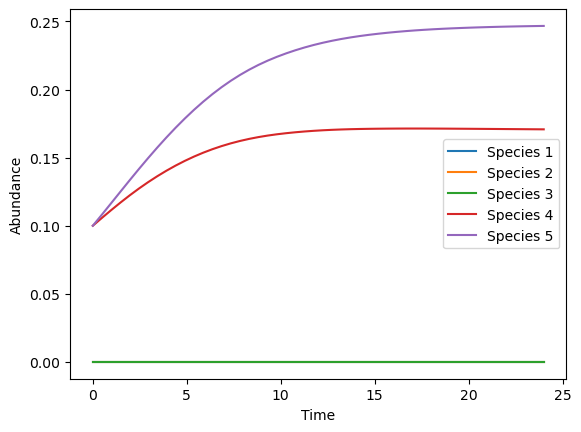

In [2]:
# simulate community abundance for a random initial condition 
init_ind = np.random.choice(np.arange(X.shape[0]))
x0 = X[init_ind]

# evaluation times 
t_eval = np.linspace(0, 24)

# run numerical ODE solver 
sim = solve_ivp(gLV, (0, t_eval[-1]), x0, t_eval=t_eval, args=(gt_params,)).y

# plot each simulated species
for i, s in enumerate(sim):
    plt.plot(t_eval, s, label=f"Species {i+1}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Abundance")
plt.show()

In [3]:
# evaluation times (more realistic to only have ~3 measurements over time)
t_eval = np.linspace(0, 24, 3)

# generate simulated data, [D]_ijk = abundance of species k at time j in sample i 
D = np.zeros([X.shape[0], len(t_eval), n_s])

for i, x0 in enumerate(X):
    # run numerical ODE solver 
    sim = solve_ivp(gLV, (0, t_eval[-1]), x0, t_eval=t_eval, args=(gt_params,)).y
    
    # save data 
    D[i] = sim.T

In [4]:
# Define an objective function 
def J(params):
    
    # initialize error 
    error = 0.
    
    # using the parameters, simulate the solution for each initial condition 
    for i, x0 in enumerate(X):
        # run numerical ODE solver 
        sim = solve_ivp(gLV, (0, t_eval[-1]), x0, t_eval=t_eval, args=(params,)).y.T
        
        # compute mean squared error 
        error += np.mean((D[i] - sim)**2) / len(X)
        
    # return error 
    return error 

def print_progress(params):
    # print the current value of the objective function
    print("Current value of objective function:", J(params))

In [5]:
# initial guess for parameters

# randomly sample growth rates between .1 and .3
r = .1*np.ones(n_s)

# randomly sample interaction values so that they're mostly negative
A = -.1*np.ones([n_s, n_s])

# the self interaction terms have to be strongly negative or else system will blow up
for i in range(n_s):
    A[i,i] = -1.
    
# package parameters as a vector
params = np.concatenate((r, A.flatten()))

In [6]:
# import optimization software 
from scipy.optimize import minimize

# run optimization 
res = minimize(J, x0=params, callback=print_progress)

Current value of objective function: 0.0025591181499631825
Current value of objective function: 0.0017525281880360708
Current value of objective function: 0.0006798982101023415
Current value of objective function: 0.0005273014857500717
Current value of objective function: 0.0005052390250968616
Current value of objective function: 0.00047054620294405047
Current value of objective function: 0.000449201322482394
Current value of objective function: 0.00044725267471481546
Current value of objective function: 0.00044426034172988384
Current value of objective function: 0.00043977935987411516
Current value of objective function: 0.0004321754847673053
Current value of objective function: 0.0004191456655488564
Current value of objective function: 0.00039731853321801376
Current value of objective function: 0.00036346651901718015
Current value of objective function: 0.00031993127759203846
Current value of objective function: 0.00026601780664531794
Current value of objective function: 0.0001891639

In [7]:
# print optimization result
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.61738290536136e-07
        x: [ 2.109e-01  1.778e-01 ... -2.550e-01 -9.612e-01]
      nit: 60
      jac: [ 7.713e-06  2.914e-06 ...  3.982e-06  1.262e-06]
 hess_inv: [[ 7.229e+00  1.398e+00 ... -2.996e+00  3.547e-01]
            [ 1.398e+00  8.042e+00 ...  2.240e+00 -6.131e-01]
            ...
            [-2.996e+00  2.240e+00 ...  6.406e+01 -9.034e+00]
            [ 3.547e-01 -6.131e-01 ... -9.034e+00  2.593e+00]]
     nfev: 1922
     njev: 62

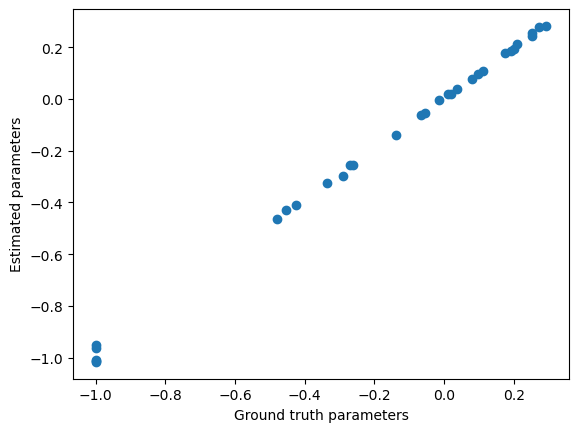

In [9]:
# compare recovered parameter values to the ground truth values
plt.scatter(gt_params, res.x)
plt.ylabel("Estimated parameters")
plt.xlabel("Ground truth parameters")
plt.show()